In [5]:
# Define paths
parent_folder = "C:/Users/Naveen/Desktop/2nd images/dataset"  # Path to the parent folder containing action folders
train_folder = "C:/Users/Naveen/Desktop/2nd images/train images"
test_folder = "C:/Users/Naveen/Desktop/2nd images/test images"

In [6]:
# Create train and test folders if they don't exist
import os
os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

In [7]:
import os
import numpy as np
import shutil

from flask import Flask, render_template, request, jsonify
import numpy as np
from PIL import Image
import os
import tensorflow as tf

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [8]:
# Function to split images into train and test sets
def split_images_into_train_test():
    for action_folder in os.listdir(parent_folder):
        action_path = os.path.join(parent_folder, action_folder)
        if os.path.isdir(action_path):
            # Create train and test folders for the action
            train_action_folder = os.path.join(train_folder, action_folder)
            test_action_folder = os.path.join(test_folder, action_folder)
            os.makedirs(train_action_folder, exist_ok=True)
            os.makedirs(test_action_folder, exist_ok=True)

            images = os.listdir(action_path)
            np.random.shuffle(images)
            train_size = int(0.8 * len(images))  # 80% train, 20% test
            train_images = images[:train_size]
            test_images = images[train_size:]

            for img in train_images:
                shutil.move(os.path.join(action_path, img), os.path.join(train_action_folder, img))
            for img in test_images:
                shutil.move(os.path.join(action_path, img), os.path.join(test_action_folder, img))

In [9]:
# Split images into train and test sets
split_images_into_train_test()

In [10]:
# Define image dimensions and other parameters
img_width, img_height = 100, 100
batch_size = 32
epochs = 10

In [11]:
# Define paths
train_data_dir = "C:/Users/Naveen/Desktop/2nd images/train images"
test_data_dir = "C:/Users/Naveen/Desktop/2nd images/test images"

In [12]:
# Use ImageDataGenerator to preprocess the images
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [13]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 1243 images belonging to 4 classes.


In [14]:
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 311 images belonging to 4 classes.


In [15]:
# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(4, activation='softmax')  # 4 output classes: allow, deny, drop, reset-both
])


In [16]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
# Train the model
model.fit(train_generator, epochs=epochs)

Epoch 1/10
39/39 [==============================] - 47s 1s/step - loss: 0.4478 - accuracy: 0.8866
Epoch 2/10
39/39 [==============================] - 40s 1s/step - loss: 0.2281 - accuracy: 0.9437
Epoch 3/10
39/39 [==============================] - 41s 1s/step - loss: 0.2046 - accuracy: 0.9477
Epoch 4/10
39/39 [==============================] - 41s 1s/step - loss: 0.1845 - accuracy: 0.9485
Epoch 5/10
39/39 [==============================] - 39s 1s/step - loss: 0.1803 - accuracy: 0.9549
Epoch 6/10
39/39 [==============================] - 42s 1s/step - loss: 0.1754 - accuracy: 0.9574
Epoch 7/10
39/39 [==============================] - 40s 1s/step - loss: 0.1528 - accuracy: 0.9614
Epoch 8/10
39/39 [==============================] - 42s 1s/step - loss: 0.1497 - accuracy: 0.9590
Epoch 9/10
39/39 [==============================] - 39s 1s/step - loss: 0.1328 - accuracy: 0.9606
Epoch 10/10
39/39 [==============================] - 39s 1s/step - loss: 0.1211 - accuracy: 0.9670


In [18]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy}')

10/10 [==============================] - 4s 340ms/step - loss: 0.1334 - accuracy: 0.9582
Test Accuracy: 0.9581993818283081


In [19]:
model.save('newmodel.h5')

C:\Users\Naveen\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from flask import Flask, render_template, request
import numpy as np
from PIL import Image, ImageDraw
import os
import tensorflow as tf

app = Flask(__name__)

# Load the saved model
loaded_model = tf.keras.models.load_model('modelnew.h5')

# Define a function to preprocess input data and convert it into images
def preprocess_input_and_convert_to_image(input_values, input_filename):
    # Create a blank image
    img = Image.new('RGB', (100, 100), color='white')

    # Initialize ImageDraw
    draw = ImageDraw.Draw(img)

    # Example: Draw a rectangle based on input values
    x0, y0 = 10, 10
    x1, y1 = 10 + input_values[0], 10 + input_values[1]
    draw.rectangle([x0, y0, x1, y1], fill='black')

    # Save the image
    img.save(input_filename)

# Define a function for making predictions with the loaded model
def predict_action(input_values):
    # Define the filename for the input image
    input_filename = 'input_image.jpg'

    # Preprocess input data and convert it into an image
    preprocess_input_and_convert_to_image(input_values, input_filename)

    # Load the image and preprocess it
    input_image = tf.keras.preprocessing.image.load_img(input_filename, target_size=(100, 100))
    input_image = tf.keras.preprocessing.image.img_to_array(input_image)
    input_image = np.expand_dims(input_image, axis=0)
    input_image /= 255.0  # Normalize the image

    # Make predictions
    prediction = loaded_model.predict(input_image)

    # Define the class labels
    class_labels = ['allow', 'drop', 'deny', 'reset-both']

    # Get the index of the class with the highest probability
    predicted_class_index = np.argmax(prediction)

    # Map the index to the corresponding class label
    predicted_class_label = class_labels[predicted_class_index]

    return predicted_class_label

@app.route('/')
def index():
    return render_template('index.html')

@app.route('/predict', methods=['POST'])
def predict():
    # Get input values from the form
    input_values = [int(request.form[f'input_{i}']) for i in range(1, 12)]

    # Make predictions
    predicted_class = predict_action(input_values)

    return render_template('result.html', predicted_class=predicted_class)

if __name__ == '__main__':
    app.run(debug=False)


 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [28/Mar/2024 09:38:16] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [28/Mar/2024 09:38:17] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [28/Mar/2024 09:38:24] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [28/Mar/2024 09:38:53] "GET / HTTP/1.1" 200 -


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 49, 49, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 23, 23, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 10, 10, 128)       0

Epoch 1/10
39/39 [==============================] - 77s 2s/step - loss: 0.1574 - accuracy: 0.9606 - val_loss: 0.2176 - val_accuracy: 0.9486
Epoch 2/10
39/39 [==============================] - 57s 1s/step - loss: 0.1536 - accuracy: 0.9574 - val_loss: 0.1612 - val_accuracy: 0.9518
Epoch 3/10
39/39 [==============================] - 65s 2s/step - loss: 0.1326 - accuracy: 0.9630 - val_loss: 0.1389 - val_accuracy: 0.9582
Epoch 4/10
39/39 [==============================] - 75s 2s/step - loss: 0.1102 - accuracy: 0.9678 - val_loss: 0.1361 - val_accuracy: 0.9646
Epoch 5/10
39/39 [==============================] - 57s 1s/step - loss: 0.1118 - accuracy: 0.9678 - val_loss: 0.1419 - val_accuracy: 0.9614
Epoch 6/10
39/39 [==============================] - 70s 2s/step - loss: 0.1000 - accuracy: 0.9686 - val_loss: 0.1513 - val_accuracy: 0.9550
Epoch 7/10
39/39 [==============================] - 65s 2s/step - loss: 0.1035 - accuracy: 0.9686 - val_loss: 0.1211 - val_accuracy: 0.9614
Epoch 8/10
39/39 [==

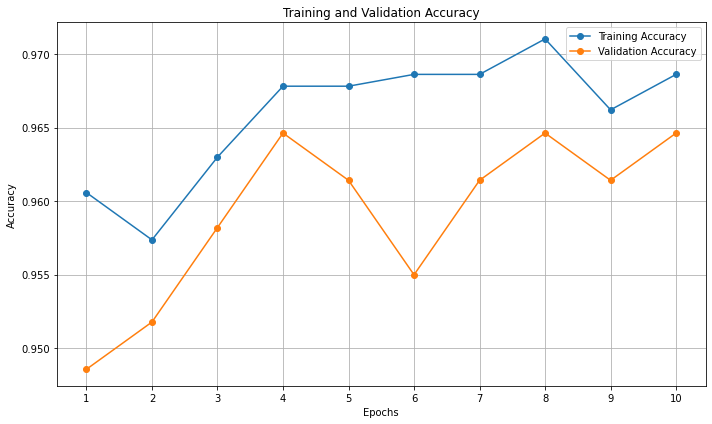

In [26]:
import matplotlib.pyplot as plt

# Train the model
history = model.fit(train_generator, epochs=epochs, validation_data=test_generator)

# Extract training history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs_range = range(1, epochs + 1)

# Plotting epochs versus accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, train_accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(epochs_range)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
